In [10]:
import os
import os.path as osp
import shutil
import meshio
from typing import List

import logging
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import numpy as np
import scipy.sparse as sp
import tqdm

from mesh_handler import xdmf_to_meshes, meshes_to_xdmf, vtu_to_mesh, mesh_to_vtu, accessing_mesh_data, create_mock_mesh, get_geometric_data, get_surface

# Create train dataset t to t+1

In [11]:
def build_data():
    """
    Creates a list of Data objects containing the following attributes:
        graph.x : [N x 7] (x, y, z, vx, vy, vz, p) at time t-1
        graph.y : [N x 7] (x, y, z, vx, vy, vz, p) at time t
        graph.edge_index : [2 x E] edge indices (i, j)
        graph.edge_attr : [E x 3] edge attributes (dx, dy, dz)
    """
    data = []
    list_files = os.listdir(osp.join(os.getcwd(), "4Students_AnXplore03"))
    list_files = [f for f in list_files if f.endswith('.xdmf')]

    for f in tqdm.tqdm(list_files[:-1]):
        # print("\n\n New file:\n")
        xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03", f)
        meshes = xdmf_to_meshes(xdmf_path, verbose=False)
        mesh = meshes[0]

        edge_index, edge_attr = get_geometric_data(mesh)

        for time_step in range(2, len(meshes)):
            # Create node features (x, y, z, vx, vy, vz, p)
            node_features_1 = np.hstack([
                meshes[time_step-1].points,
                meshes[time_step-1].point_data['Vitesse'],
                meshes[time_step-1].point_data['Pression'].reshape(-1, 1)
            ]) # Shape: (num_nodes, 7)
            node_features_1 = torch.tensor(node_features_1, dtype=torch.float)
            node_features = np.hstack([
                meshes[time_step].points,
                meshes[time_step].point_data['Vitesse'],
                meshes[time_step].point_data['Pression'].reshape(-1, 1)
            ]) # Shape: (num_nodes, 7)
            node_features = torch.tensor(node_features, dtype=torch.float)

            # Create PyTorch Geometric data object
            graph_data = Data(
                x=node_features_1,
                y=node_features,
                edge_index=edge_index,
                edge_attr=edge_attr
            )

            data.append(graph_data)
    return data

In [12]:
data = build_data()

100%|██████████| 102/102 [01:35<00:00,  1.06it/s]


In [13]:
data[0]

Data(x=[11446, 7], edge_index=[2, 110854], edge_attr=[110854, 3], y=[11446, 7])

In [14]:
len(data)

7956

# Create test dataset t and t+1 to t+2 + limit conditions

In [18]:
xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03/AllFields_Resultats_MESH_1.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
mesh = meshes[0]
surface = get_surface(mesh)
surface

Loaded 80 timesteps from AllFields_Resultats_MESH_1.xdmf



array([1., 1., 1., ..., 0., 0., 0.], shape=(11446,))

In [21]:
def build_data_two():
    """
    Creates a dataset with the following structure:
    - features: list of Data objects containing the features at time t-2 and t-1
        graph.x : [N x 16] (x, y, z, vx, vy, vz, p, S, x, y, z, vx, vy, vz, p, S)
        S is a boolean indicating if the point is on the surface (limit condition)
    - target: list of Data objects containing the features at time t
        graph.x : [N x 8] (x, y, z, vx, vy, vz, p, S)
    """
    data = {
        'features' : [],
        'target' : []
    }
    list_files = os.listdir(osp.join(os.getcwd(), "4Students_AnXplore03"))
    list_files = [f for f in list_files if f.endswith('.xdmf')]

    for f in tqdm.tqdm(list_files[:-1]):
        # print("\n\n New file:\n")
        xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03", f)
        meshes = xdmf_to_meshes(xdmf_path, verbose=False)
        mesh = meshes[0]
        surface = get_surface(mesh)
        edge_index, edge_attr = get_geometric_data(mesh)

        for time_step in range(2, len(meshes)):
            # Create node features (x, y, z, vx, vy, vz, p)
            node_features_2 = np.hstack([
                meshes[time_step-2].points,
                meshes[time_step-2].point_data['Vitesse'],
                meshes[time_step-2].point_data['Pression'].reshape(-1, 1),
                surface.reshape(-1, 1)
            ]) # Shape: (num_nodes, 7)
            node_features_2 = torch.tensor(node_features_2, dtype=torch.float)
            node_features_1 = np.hstack([
                meshes[time_step-1].points,
                meshes[time_step-1].point_data['Vitesse'],
                meshes[time_step-1].point_data['Pression'].reshape(-1, 1),
                surface.reshape(-1, 1)
            ]) # Shape: (num_nodes, 7)
            node_features_1 = torch.tensor(node_features_1, dtype=torch.float)
            node_features = np.hstack([
                meshes[time_step].points,
                meshes[time_step].point_data['Vitesse'],
                meshes[time_step].point_data['Pression'].reshape(-1, 1),
                surface.reshape(-1, 1)
            ]) # Shape: (num_nodes, 7)
            node_features = torch.tensor(node_features, dtype=torch.float)

            # Create PyTorch Geometric data object
            # concat data at t-2 and t-1
            graph_data_features = Data(
                x=torch.cat((node_features_2, node_features_1), 1),
                edge_index=edge_index,
                edge_attr=edge_attr
            )
            graph_data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

            data['features'].append(graph_data_features)
            data['target'].append(graph_data)
    return data

In [20]:
data_two = build_data_two()

100%|██████████| 102/102 [01:30<00:00,  1.12it/s]


In [23]:
data_two['features'][0]

Data(x=[11446, 16], edge_index=[2, 110854], edge_attr=[110854, 3])

In [24]:
data_two['target'][0]

Data(x=[11446, 8], edge_index=[2, 110854], edge_attr=[110854, 3])

In [25]:
data_two.keys()

dict_keys(['features', 'target'])

In [26]:
len(data_two['features'])

7956

# Predict only zero to compare to a baseline

In [27]:
from models.ZeroPredictor import ZeroPredictor

In [38]:
model = ZeroPredictor()
xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03", "AllFields_Resultats_MESH_219.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
total_error, list_errors = model.test_model(meshes)

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_219.xdmf

Total error: 2.6491


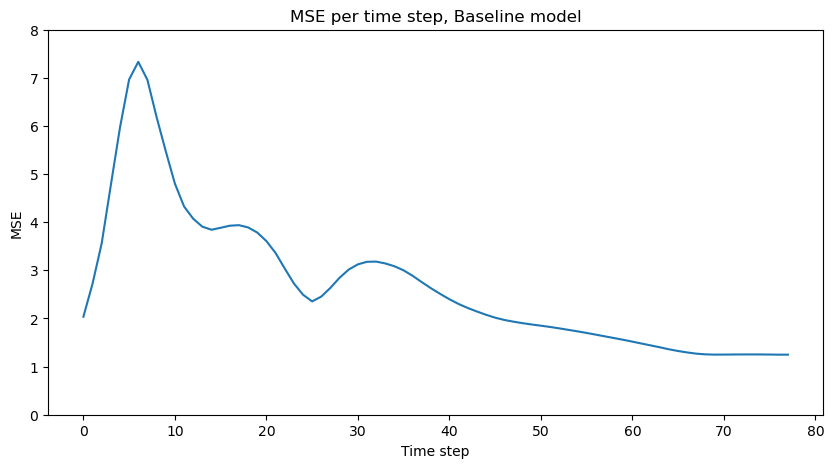

In [39]:
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.figure(figsize=(10, 5))

plt.plot(np.array(list_errors, dtype=np.float32))
plt.ylim(0, 8)
plt.xlabel("Time step")
plt.ylabel("MSE")
plt.title("MSE per time step, Baseline model")
plt.savefig("MSE_per_time_step.png")
plt.savefig("MSE_per_time_step.png")
plt.show()

# Predict mean of first 3 values

In [ ]:
from MeanPredictor import MeanPredictor

In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import numpy as np
import tqdm

from mesh_handler import get_geometric_data

class MeanPredictor(torch.nn.Module):
    def __init__(self, input_dim=7, hidden_dim=64, output_dim=3):
        super(MeanPredictor, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.mean = None # [mean_vx, mean_vy, mean_vz], of size (N, 3)
    
    def train_model(self, meshes):
        # compute the mean of the velocities for first 3 time steps
        # updates self.mean

        v0 = meshes[0].point_data['Vitesse']
        v1 = meshes[1].point_data['Vitesse']
        v2 = meshes[2].point_data['Vitesse']
        self.mean = np.mean([v0, v1, v2], axis=0)
        print(f"Mean velocities of shape : {self.mean.shape}\n\n {self.mean}")

    def forward(self):
        # Return [mean_vx, mean_vy, mean_vz]
        pred = torch.tensor(self.mean, dtype=torch.float)
        return pred
    
    def test_model(self, meshes):
        # test the model on a sequence of meshes
        # start from time t=2 and predict each step until the end
        # use the previous time steps to predict the next one
        # the final error is 1/T * sum_t sqrt(1/N * sum_n (x_t - x_t_pred)^2)

        # create the ground truth data
        edge_index, edge_attr = get_geometric_data(meshes[0])
        x_list_truth = []
        for time_step in range(len(meshes)):
            node_features = np.hstack([
                meshes[time_step].points,
                meshes[time_step].point_data['Vitesse'],
                meshes[time_step].point_data['Pression'].reshape(-1, 1)
            ]) # Shape: (num_nodes, 7)
            node_features = torch.tensor(node_features, dtype=torch.float)
            x_list_truth.append(node_features)

        graph_data = Data(x=x_list_truth[1], edge_index=edge_index, edge_attr=edge_attr)

        # predict each time step
        total_error = 0
        list_errors = []
        for i in range(2, len(meshes)):
            v = self.forward()
            v_truth = x_list_truth[i][:, 3:6]
            
            error = F.mse_loss(v, v_truth)/len(meshes[0].points)
            list_errors.append(error.item())
            total_error += error.item()

        total_error /= len(meshes)
        print(f"Total error: {total_error:.4f}")
        return total_error, list_errors

In [16]:
model = MeanPredictor()
xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03", "AllFields_Resultats_MESH_219.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
model.train_model(meshes)
total_error, list_errors = model.test_model(meshes)

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_219.xdmf

Mean velocities of shape : (11364, 3)

 [[-3.7708682e-13 -9.3329783e-14  1.3394536e-13]
 [-7.7942194e-13 -2.3022418e-13  1.4884032e-13]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 ...
 [ 1.6650307e+02 -1.6343834e+02 -1.9401361e+00]
 [ 9.8446411e+01  1.5294223e+02  1.6166740e+01]
 [ 1.2832561e+02 -3.3332870e+00 -1.7273294e+01]]
Total error: 0.2780


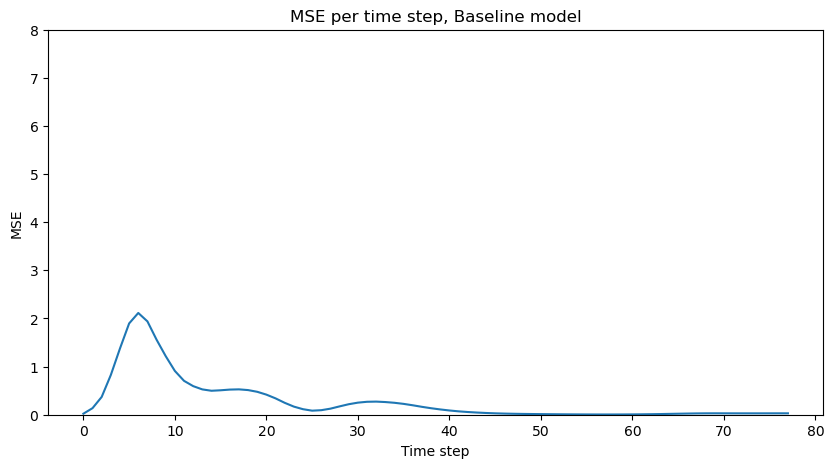

In [17]:
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.figure(figsize=(10, 5))

plt.plot(np.array(list_errors, dtype=np.float32))
plt.ylim(0, 8)
plt.xlabel("Time step")
plt.ylabel("MSE")
plt.title("MSE per time step, Baseline model")
plt.savefig("MSE_per_time_step.png")
plt.savefig("MSE_per_time_step.png")
plt.show()

In [40]:
def predict_mean(file):
    """
    Predicts all time steps using the given model
    model : MeanPredictor (torch.nn.Module)
    file : (str) path to a .xdmf file with only the three first 
    time steps that are filled (and limit conditions for all time steps)
    """

    # get the meshes
    meshes = xdmf_to_meshes(f"{file}.xdmf", verbose=False)
    print(len(meshes))
    print(meshes[0])
    predicted_meshes = meshes[:3]
    # print(meshes)
    print(f"{meshes[3].point_data['Vitesse'].nonzero()[0].shape} non zero speed values in the third time step")
    # print(f"{meshes[10].point_data['Vitesse'].nonzero()[0].shape} non zero speed values in the 10th time step")
    print(f"{meshes[3].point_data['Pression'].nonzero()[0].shape} non zero pression values in the third time step")

    model = MeanPredictor()
    model.train_model(meshes)

    v_list_pred = [
        meshes[0].point_data['Vitesse'],
        meshes[1].point_data['Vitesse'],
        meshes[2].point_data['Vitesse']
        ]

    for time_step in range(3, len(meshes)):
        # print(f"Predicting time step {time_step}")
        v_pred = model.forward()
       
        v_list_pred.append(v_pred.cpu().detach().numpy())

        # update predicted_meshes
        pred_mesh = meshes[time_step].copy()
        pred_mesh.point_data['Vitesse'] = v_pred.cpu().detach().numpy()
        predicted_meshes.append(pred_mesh)
    
    print(f"{predicted_meshes[3].point_data['Vitesse'].nonzero()[0].shape} non zero speed values in the third time step")
    print(f"{predicted_meshes[3].point_data['Pression'].nonzero()[0].shape} non zero pression values in the third time step")
    print(f"{predicted_meshes[10].point_data['Vitesse'].nonzero()[0].shape} non zero speed values in the 10th time step")
    print(f"{predicted_meshes[10].point_data['Pression'].nonzero()[0].shape} non zero pression values in the 10th time step")

    file_name_pred = osp.join(
        os.getcwd(),
        f"{file}_predicted.xdmf"
    )
    print(f"Saving predicted meshes to {file_name_pred}")
    meshes_to_xdmf(file_name_pred, predicted_meshes)
    return v_list_pred

    
test_file = "IDSC2025_AnXplore_cropped_test_case/4Students_test_case_cropped/TEST_AllFields_Resultats_MESH_1"
folder_path = osp.join(os.getcwd(), test_file)
v_list_pred = predict_mean(folder_path)

80
<meshio mesh object>
  Number of points: 11446
  Number of cells:
    tetra: 55472
  Point data: Vitesse, Pression
(284,) non zero speed values in the third time step
(176,) non zero pression values in the third time step
Mean velocities of shape : (11446, 3)

 [[ 3.3425620e-13 -1.7035986e-14 -8.9197835e-14]
 [ 1.3281642e-13 -1.4637968e-14 -3.2407125e-14]
 [-1.5653147e-13  3.5109512e-14  2.7174199e-14]
 ...
 [ 5.6644815e-01 -1.3842656e+01  9.9625006e+00]
 [ 3.1549466e+02 -7.0885872e+01 -1.5113538e+01]
 [ 1.5478377e+02 -3.4617542e+02  1.1962168e+00]]
(30723,) non zero speed values in the third time step
(176,) non zero pression values in the third time step
(30723,) non zero speed values in the 10th time step
(176,) non zero pression values in the 10th time step
Saving predicted meshes to c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\IDSC2025_AnXplore_cropped_test_case/4Students_test_case_cropped/TEST_AllFields_Resultats_MESH_1_predicted.xdmf
Time ser

In [41]:
v_list_pred = np.array(v_list_pred)
v_list_pred

array([[[ 2.81161270e-13, -1.73838452e-14, -7.70491323e-14],
        [ 1.12672180e-13, -1.37880531e-14, -2.82337630e-14],
        [-1.34961812e-13,  3.20408983e-14,  2.40435198e-14],
        ...,
        [ 9.14276600e-01, -1.43040590e+01,  1.10745163e+01],
        [ 2.87247559e+02, -6.33707161e+01, -1.44549007e+01],
        [ 1.42823685e+02, -3.17690613e+02,  6.38828278e-01]],

       [[ 3.31998833e-13, -1.13034624e-14, -8.58322406e-14],
        [ 1.31918795e-13, -1.22454579e-14, -3.12071705e-14],
        [-1.55164306e-13,  3.21878415e-14,  2.62503032e-14],
        ...,
        [ 1.55023360e+00, -1.31981125e+01,  9.80464268e+00],
        [ 3.11076477e+02, -7.06360703e+01, -1.54602461e+01],
        [ 1.52733749e+02, -3.41872131e+02,  1.09566641e+00]],

       [[ 3.89608511e-13, -2.24206504e-14, -1.04712124e-13],
        [ 1.53858290e-13, -1.78803895e-14, -3.77804376e-14],
        [-1.79468311e-13,  4.10997937e-14,  3.12287732e-14],
        ...,
        [-7.65165746e-01, -1.40257998e+01,

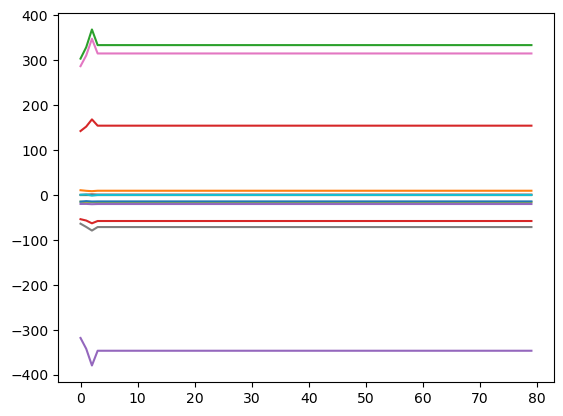

In [42]:
for i in range(5):
    plt.plot(
        v_list_pred[:, -i, :]
    )

In [43]:
test_file = "4Students_Validation_cases_cropped-20250124T100628Z-001/4Students_Validation_cases_cropped/VAL_AllFields_Resultats_MESH_160"
folder_path = osp.join(os.getcwd(), test_file)
v_list_pred = predict_mean(folder_path)

80
<meshio mesh object>
  Number of points: 13082
  Number of cells:
    tetra: 64148
  Point data: Vitesse, Pression
(313,) non zero speed values in the third time step
(207,) non zero pression values in the third time step
Mean velocities of shape : (13082, 3)

 [[ 3.5199252e-13 -3.3492401e-13 -9.2674695e-14]
 [ 1.6094950e-13 -1.4341783e-13 -3.3392360e-14]
 [ 5.7135324e-13 -5.0142139e-13 -9.2874960e-14]
 ...
 [ 2.8988513e+02 -2.3468056e+02 -9.7285157e-01]
 [ 3.2947238e+02 -1.7699138e+02  9.1611681e+00]
 [-1.2152508e+01 -3.6326580e+01  4.0566978e+00]]
(35024,) non zero speed values in the third time step
(207,) non zero pression values in the third time step
(35024,) non zero speed values in the 10th time step
(207,) non zero pression values in the 10th time step
Saving predicted meshes to c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_Validation_cases_cropped-20250124T100628Z-001/4Students_Validation_cases_cropped/VAL_AllFields_Resultats_MESH

In [44]:
v_list_pred = np.array(v_list_pred)
v_list_pred

array([[[ 3.1978887e-13, -2.9629378e-13, -8.2113109e-14],
        [ 1.4458172e-13, -1.2635457e-13, -2.9449316e-14],
        [ 5.1135615e-13, -4.4150401e-13, -8.1678194e-14],
        ...,
        [ 2.6319366e+02, -2.1385570e+02, -7.9408920e-01],
        [ 3.0110660e+02, -1.6179140e+02,  8.2353029e+00],
        [-1.2037744e+01, -3.6908768e+01,  4.0032897e+00]],

       [[ 3.4903485e-13, -3.2404629e-13, -9.0034324e-14],
        [ 1.5951366e-13, -1.3874608e-13, -3.2395964e-14],
        [ 5.6674544e-13, -4.8527870e-13, -9.0161094e-14],
        ...,
        [ 2.8587646e+02, -2.3161551e+02, -8.3188027e-01],
        [ 3.2496103e+02, -1.7511285e+02,  9.0398216e+00],
        [-1.1602595e+01, -3.5944923e+01,  3.9848144e+00]],

       [[ 3.8715380e-13, -3.8443202e-13, -1.0587665e-13],
        [ 1.7875312e-13, -1.6515283e-13, -3.8331809e-14],
        [ 6.3595819e-13, -5.7748137e-13, -1.0678558e-13],
        ...,
        [ 3.2058530e+02, -2.5857050e+02, -1.2925855e+00],
        [ 3.6234955e+02, -1.9

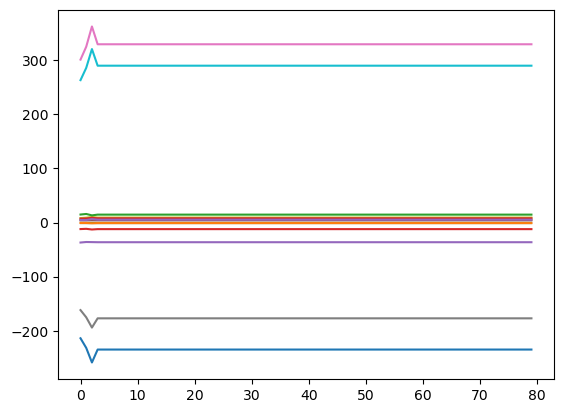

In [45]:
for i in range(5):
    plt.plot(
        v_list_pred[:, -i, :]
    )

In [46]:
test_file = "4Students_Validation_cases_cropped-20250124T100628Z-001/4Students_Validation_cases_cropped/VAL_AllFields_Resultats_MESH_167"
folder_path = osp.join(os.getcwd(), test_file)
v_list_pred = predict_mean(folder_path)

80
<meshio mesh object>
  Number of points: 12268
  Number of cells:
    tetra: 59995
  Point data: Vitesse, Pression
(266,) non zero speed values in the third time step
(192,) non zero pression values in the third time step
Mean velocities of shape : (12268, 3)

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  3.56679990e-13  0.00000000e+00]
 ...
 [ 2.98991180e+02  3.29376259e+01  3.46208496e+01]
 [ 3.85316582e+01 -2.41173706e+01  2.12123089e+01]
 [ 3.42529022e+02 -1.09626526e+02 -9.60763836e+00]]
(32966,) non zero speed values in the third time step
(192,) non zero pression values in the third time step
(32966,) non zero speed values in the 10th time step
(192,) non zero pression values in the 10th time step
Saving predicted meshes to c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_Validation_cases_cropped-20250124T100628Z-001/4Students_Validation_cases_cropped/VAL_AllFie

# Message passing model, t to t+1

In [10]:
from models.GNNPredictor import GNNPredictor

In [27]:
dataset = data[:1000] # use only the first 100 time steps for computational reasons

# Create a DataLoader with batch support
batch_size = 16
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate Model and Optimizer
model = GNNPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [23]:
# Train the model
model.train_model(loader, optimizer, epochs=2)

# Save model
torch.save(model.state_dict(), "trained_models/gnn_model_small_data_10_epochs.pth")

print("Training complete!")

 10%|█         | 1/10 [00:06<01:01,  6.82s/it]

Epoch 0 | Loss: 1609330.8672


100%|██████████| 10/10 [01:10<00:00,  7.06s/it]

Training complete!


In [24]:
# load model from gnn_model.pth file
model = GNNPredictor()
model.load_state_dict(torch.load("trained_models/gnn_model_small_data_10_epochs.pth"))
xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03", "AllFields_Resultats_MESH_219.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
total_error, list_errors = model.test_model(meshes)

C:\Users\alexi\AppData\Local\Temp\ipykernel_64136\485948237.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("trained_models/gnn_model_sm

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_219.xdmf

Total error: 2.2920


In [42]:
# debug code for some error I honestly didn't understand that made the kernel crash
# import os
# import matplotlib
# import shutil

# cache_dir = matplotlib.get_cachedir()
# shutil.rmtree(cache_dir)

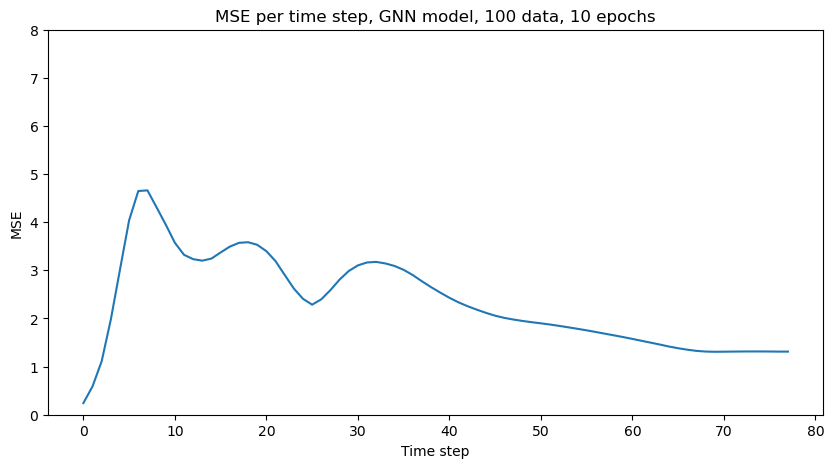

In [25]:
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.figure(figsize=(10, 5))

plt.plot(np.array(list_errors, dtype=np.float32))
plt.ylim(0, 8)
plt.xlabel("Time step")
plt.ylabel("MSE")
plt.title("MSE per time step, GNN model, 100 data, 10 epochs")
plt.savefig("MSE_per_time_step.png")
plt.show()

# Adam model : LSTMModel2

In [6]:
from models.LSTMModel2 import LSTMModel2

In [7]:
dataset = data[:20] # use only the first 100 time steps for computational reasons

# Create a DataLoader with batch support
batch_size = 16
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate Model and Optimizer
model = LSTMModel2()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

c:\miniconda\envs\idsc_challenge_jan\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [8]:
# Train the model
model.train_model(loader, optimizer, epochs=10)

# Save model
torch.save(model.state_dict(), "trained_models/LSTMModel2_small_data_10_epochs.pth")

print("Training complete!")

 10%|█         | 1/10 [00:05<00:49,  5.54s/it]

Epoch 0 | Loss: 88802.6797


100%|██████████| 10/10 [00:36<00:00,  3.62s/it]

Training complete!


In [9]:
# load model from gnn_model.pth file
model = LSTMModel2()
model.load_state_dict(torch.load("trained_models/LSTMModel2_small_data_10_epochs.pth"))
xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03", "AllFields_Resultats_MESH_219.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
total_error, list_errors = model.test_model(meshes)

C:\Users\alexi\AppData\Local\Temp\ipykernel_64136\2237888627.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("trained_models/LSTMModel2_

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_219.xdmf

x_list_truth[0].shape = torch.Size([11364, 7])
Initial graph_data.x shape: torch.Size([11364, 7])
Total error: 2.6206


In [ ]:
# debug code for some error I honestly didn't understand that made the kernel crash
# import os
# import matplotlib
# import shutil

# cache_dir = matplotlib.get_cachedir()
# shutil.rmtree(cache_dir)

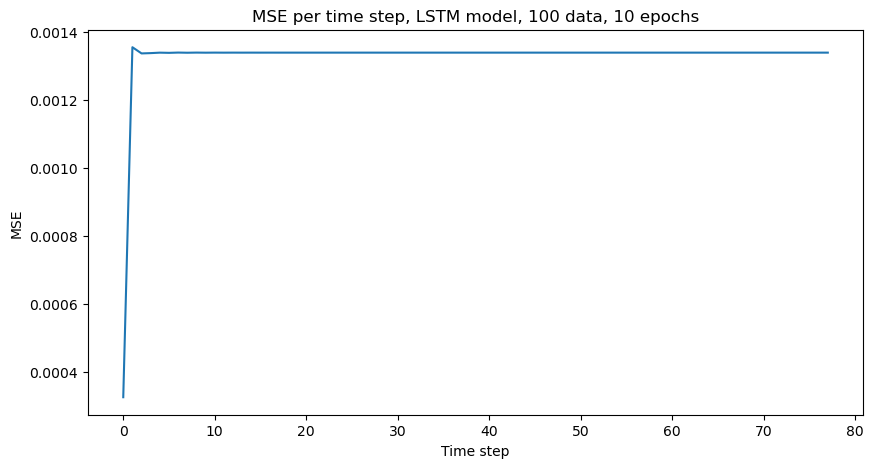

In [12]:
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.figure(figsize=(10, 5))

plt.plot(np.array(list_errors, dtype=np.float32))
# plt.ylim(0, 8)
plt.xlabel("Time step")
plt.ylabel("MSE")
plt.title("MSE per time step, LSTM model, 100 data, 10 epochs")
plt.savefig("MSE_per_time_step.png")
plt.show()

# Message passing model with RNN (RecurrentGNN)

In [2]:
from models.RecurrentGNN import RecurrentGNN

In [34]:
dataset = data[:100] # use only the first 100 time steps for computational reasons

# Create a DataLoader with batch support
batch_size = 16
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate Model and Optimizer
model = RecurrentGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

c:\miniconda\envs\idsc_challenge_jan\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


: 

In [46]:
# Train the model
model.train_model(loader, optimizer, epochs=10)

# Save model
torch.save(model.state_dict(), "trained_models/recurrent_gnn_model_small_data_3_epochs.pth")

print("Training complete!")

 10%|█         | 1/10 [10:47<1:37:06, 647.43s/it]

Epoch 0 | Loss: 7516435.5938


 30%|███       | 3/10 [52:28<2:14:22, 1151.81s/it]

In [3]:
# load model from gnn_model.pth file
model = RecurrentGNN()
model.load_state_dict(torch.load("trained_models/recurrent_gnn_model_small_data_3_epochs.pth", weights_only=True))
xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03", "AllFields_Resultats_MESH_219.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
total_error, list_errors = model.test_model(meshes)

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_219.xdmf

Total error: 2.5815


In [48]:
# debug code for some error I honestly didn't understand that made the kernel crash
# import os
# import matplotlib
# import shutil

# cache_dir = matplotlib.get_cachedir()
# shutil.rmtree(cache_dir)

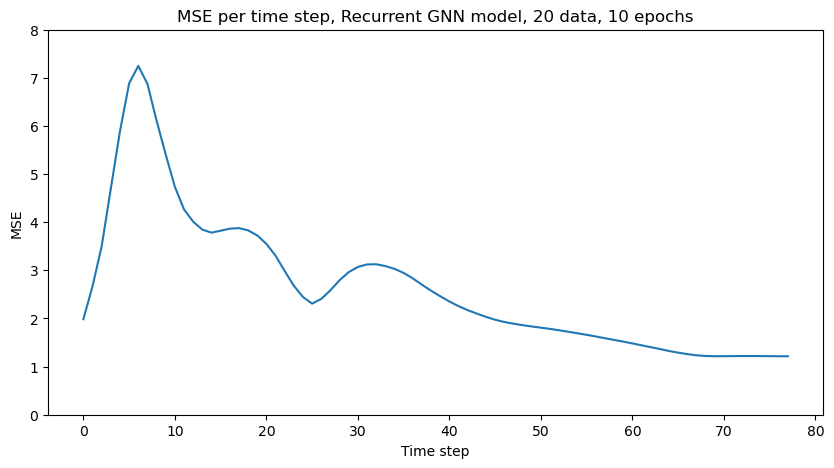

In [ ]:
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.figure(figsize=(10, 5))

plt.plot(np.array(list_errors, dtype=np.float32))
plt.ylim(0, 8)
plt.xlabel("Time step")
plt.ylabel("MSE")
plt.title("MSE per time step, Recurrent GNN model, 20 data, 10 epochs")
plt.savefig("MSE_per_time_step.png")
plt.show()

# Message passing model with RNN and two time steps (RecurrentDoubleGNN)

In [6]:
from models.RecurrentDoubleGNN import RecurrentDoubleGNN

In [21]:
dataset = [
    (data_two['features'][i], data_two['target'][i])
    for i in range(20) # use only the first 100 time steps for computational reasons
    # for i in range(len(data['features']))
]

# Create a DataLoader with batch support
batch_size = 16
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Instantiate Model and Optimizer
model = RecurrentDoubleGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [22]:
# Train the model
model.train_model(loader, optimizer, epochs=5)

# Save model
torch.save(model.state_dict(), "trained_models/recurrent_double_gnn_model_5_epochs.pth")

print("Training complete!")

 20%|██        | 1/5 [01:10<04:41, 70.27s/it]

Epoch 0 | Loss: 3391176.0000


100%|██████████| 5/5 [05:30<00:00, 66.11s/it]


Training complete!


In [7]:
# load model from gnn_model.pth file
model = RecurrentDoubleGNN()
model.load_state_dict(torch.load("trained_models/recurrent_double_gnn_model_5_epochs.pth", weights_only=True))
xdmf_path = osp.join(os.getcwd(), "4Students_AnXplore03", "AllFields_Resultats_MESH_219.xdmf")
meshes = xdmf_to_meshes(xdmf_path)
total_error, list_errors = model.test_model(meshes)

Loaded 80 timesteps from c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\4Students_AnXplore03\AllFields_Resultats_MESH_219.xdmf



100%|██████████| 78/78 [02:49<00:00,  2.17s/it]


Total error: 2.6404


In [8]:
# debug code for some error I honestly didn't understand that made the kernel crash
# import os
# import matplotlib
# import shutil

# cache_dir = matplotlib.get_cachedir()
# shutil.rmtree(cache_dir)

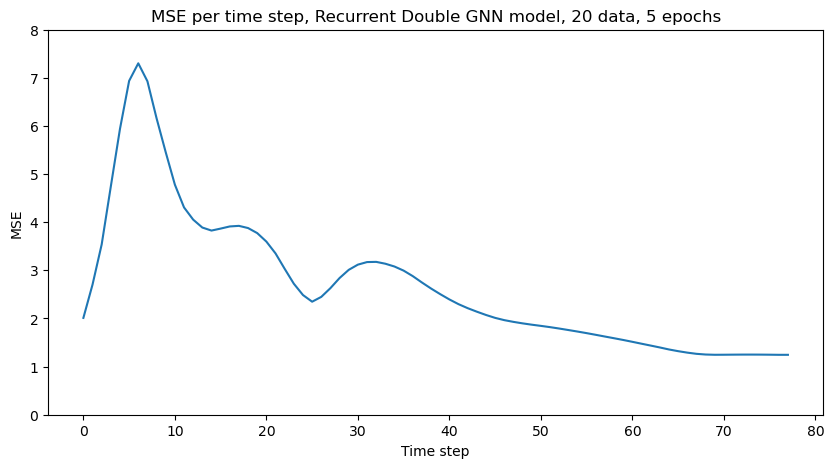

In [9]:
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.figure(figsize=(10, 5))

plt.plot(np.array(list_errors, dtype=np.float32))
plt.ylim(0, 8)
plt.xlabel("Time step")
plt.ylabel("MSE")
plt.title("MSE per time step, Recurrent Double GNN model, 20 data, 5 epochs")
plt.savefig("MSE_per_time_step.png")
plt.show()

# Predict on real test dataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
from models.LSTMModel2 import LSTMModel2

model = LSTMModel2()
model.load_state_dict(torch.load("trained_models/LSTMModel2_mid_data_10_epochs.pth"))

def predict(model, file):
    """
    Predicts all time steps using the given model
    model : LSTMModel2 (torch.nn.Module)
    file : (str) path to a .xdmf file with only the three first 
    time steps that are filled (and limit conditions for all time steps)
    """
    model.eval()

    # get the meshes
    meshes = xdmf_to_meshes(file, verbose=False)
    print(len(meshes))
    predicted_meshes = meshes[:3]
    # print(meshes)
    print(f"{meshes[3].point_data['Vitesse'].nonzero()[0].shape} non zero speed values in the third time step")
    # print(f"{meshes[10].point_data['Vitesse'].nonzero()[0].shape} non zero speed values in the 10th time step")
    print(f"{meshes[3].point_data['Pression'].nonzero()[0].shape} non zero pression values in the third time step")

    edge_index, edge_attr = get_geometric_data(meshes[0])
    edge_index = edge_index.to(device)
    edge_attr = edge_attr.to(device)

    # Initialiser les données pour la prédiction
    node_features = np.hstack([
        meshes[2].points,  # Positions (x, y, z)
        meshes[2].point_data['Vitesse'],  # Vitesses (vx, vy, vz)
        meshes[2].point_data['Pression'].reshape(-1, 1)  # Pression
    ])  # Shape: (num_nodes, 7)
    x = torch.tensor(node_features, dtype=torch.float).to(device)
    hidden_state, cell_state = None, None
    x_list_pred = [meshes[2].point_data['Vitesse']]

    for time_step in range(3, len(meshes)):
        # print(f"Predicting time step {time_step}")
        x_pred, hidden_state, cell_state = model.forward(x, edge_index, hidden_state, cell_state)

        x = torch.cat([
            torch.tensor(meshes[0].points, dtype=torch.float, device=x_pred.device),  # Les positions restent inchangées
            x_pred,  # Les vitesses prédites
            x[:, 6:7]  # La pression (dernière colonne de l'entrée précédente)
        ], dim=1)
        x_list_pred.append(x_pred.cpu().detach().numpy())

        # update predicted_meshes
        pred_mesh = meshes[time_step].copy()
        pred_mesh.point_data['Vitesse'] = x_pred.cpu().detach().numpy()
        pred_mesh.point_data['Pression'] = x[:, 6].cpu().detach().numpy()
        predicted_meshes.append(pred_mesh)
    
    print(f"{predicted_meshes[3].point_data['Vitesse'].nonzero()[0].shape} non zero speed values in the third time step")
    print(f"{predicted_meshes[3].point_data['Pression'].nonzero()[0].shape} non zero pression values in the third time step")
    print(f"{predicted_meshes[10].point_data['Vitesse'].nonzero()[0].shape} non zero speed values in the 10th time step")
    print(f"{predicted_meshes[10].point_data['Pression'].nonzero()[0].shape} non zero pression values in the 10th time step")

    file_name_pred = osp.join(os.getcwd(), "IDSC2025_AnXplore_cropped_test_case/4Students_test_case_cropped/predicted.xdmf")
    print(f"Saving predicted meshes to {file_name_pred}")
    # if osp.exists(file_name_pred):
    #     os.remove()file_name_pred
    meshes_to_xdmf(file_name_pred, predicted_meshes)
    return x_list_pred

    
test_file = "IDSC2025_AnXplore_cropped_test_case/4Students_test_case_cropped/TEST_AllFields_Resultats_MESH_1.xdmf"
folder_path = osp.join(os.getcwd(), test_file)
x_list_pred = predict(model, folder_path)

C:\Users\alexi\AppData\Local\Temp\ipykernel_58008\936772702.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("trained_models/LSTMModel2_m

80
(284,) non zero speed values in the third time step
(176,) non zero pression values in the third time step
(34338,) non zero speed values in the third time step
(11446,) non zero pression values in the third time step
(34338,) non zero speed values in the 10th time step
(11446,) non zero pression values in the 10th time step
Saving predicted meshes to c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\IDSC2025_AnXplore_cropped_test_case/4Students_test_case_cropped/predicted.xdmf
Time series written to c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\IDSC2025_AnXplore_cropped_test_case/4Students_test_case_cropped/predicted.xdmf and c:\Users\alexi\Documents\mines\S5\idsc\data challenge janvier\aneurysm_project\IDSC2025_AnXplore_cropped_test_case/4Students_test_case_cropped/predicted.h5


In [20]:
x_list_pred

[array([[ 3.89608511e-13, -2.24206504e-14, -1.04712124e-13],
        [ 1.53858290e-13, -1.78803895e-14, -3.77804376e-14],
        [-1.79468311e-13,  4.10997937e-14,  3.12287732e-14],
        ...,
        [-7.65165746e-01, -1.40257998e+01,  9.00834179e+00],
        [ 3.48159973e+02, -7.86508255e+01, -1.54254704e+01],
        [ 1.68793869e+02, -3.78963531e+02,  1.85415578e+00]],
       shape=(11446, 3), dtype=float32),
 array([[ 0.6653208 ,  5.3064055 ,  0.25294417],
        [ 0.7947847 ,  6.280107  ,  0.2442867 ],
        [ 1.2876376 ,  5.987255  ,  0.1185531 ],
        ...,
        [ 0.54667485,  7.557311  ,  0.3955866 ],
        [ 2.2472193 ,  6.2367644 ,  0.18659133],
        [ 4.5687575 ,  4.699953  , -0.03631232]],
       shape=(11446, 3), dtype=float32),
 array([[-0.26977894,  7.637057  ,  0.3117539 ],
        [-0.3273848 ,  7.5783577 ,  0.29889178],
        [-0.29206476,  7.6053977 ,  0.30461594],
        ...,
        [ 0.6807138 ,  7.110108  ,  0.26812422],
        [ 0.70693004,

In [22]:
x_list_pred = np.array(x_list_pred)
x_list_pred

array([[[ 3.89608511e-13, -2.24206504e-14, -1.04712124e-13],
        [ 1.53858290e-13, -1.78803895e-14, -3.77804376e-14],
        [-1.79468311e-13,  4.10997937e-14,  3.12287732e-14],
        ...,
        [-7.65165746e-01, -1.40257998e+01,  9.00834179e+00],
        [ 3.48159973e+02, -7.86508255e+01, -1.54254704e+01],
        [ 1.68793869e+02, -3.78963531e+02,  1.85415578e+00]],

       [[ 6.65320814e-01,  5.30640554e+00,  2.52944171e-01],
        [ 7.94784725e-01,  6.28010702e+00,  2.44286701e-01],
        [ 1.28763759e+00,  5.98725510e+00,  1.18553102e-01],
        ...,
        [ 5.46674848e-01,  7.55731106e+00,  3.95586610e-01],
        [ 2.24721932e+00,  6.23676443e+00,  1.86591327e-01],
        [ 4.56875753e+00,  4.69995308e+00, -3.63123231e-02]],

       [[-2.69778937e-01,  7.63705683e+00,  3.11753899e-01],
        [-3.27384800e-01,  7.57835770e+00,  2.98891783e-01],
        [-2.92064756e-01,  7.60539770e+00,  3.04615945e-01],
        ...,
        [ 6.80713773e-01,  7.11010790e+00,

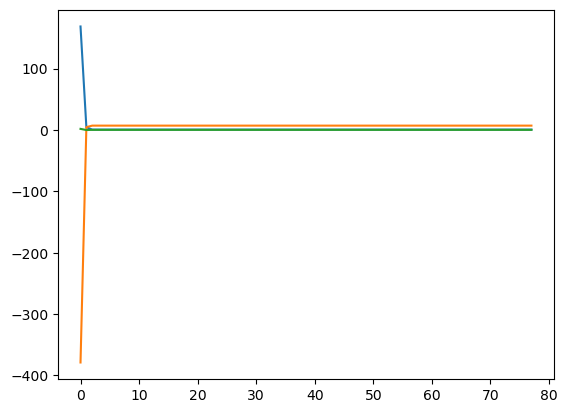

In [25]:
plt.plot(
    x_list_pred[:, -1, :]
)